## Combined KNN and Logistic Regression
### Anshurup gupta 2301ai02

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
err = 1.0e-9    # addtional term for precision and to avoid divide by zero error and such

# base class to manipulate pandas data frame
class BaseData:
    def __init__(self, df: pd.DataFrame, dataSplit):
        self.accuracy = 0
        self.count_val = []

        freq = df["diagnosis"].value_counts()
        #print(freq)

        indexb = int(freq[0] * dataSplit)
        indexm = freq[0] + int(freq[1] * dataSplit)
        #print(indexb, indexm)

        # evenly splitting the samples for test and train
        self.train_data = pd.concat([df.iloc[:indexb], df.iloc[freq[0] + 1:indexm]], axis= 0).reset_index(drop= True)
        self.test_data = pd.concat([df.iloc[indexb:freq[0] + 1], df.iloc[indexm:]], axis= 0).reset_index(drop= True)
        
        # Shuffle the DataFrame
        self.train_data = self.train_data.sample(frac=1).reset_index(drop=True)
        self.test_data = self.test_data.sample(frac=1).reset_index(drop=True)

        #print("train: ",self.train_data["diagnosis"].value_counts())
        #print("test: ",self.test_data["diagnosis"].value_counts())

    # normalisation (required for regression)
    def normalise(self, matrix_val : np.array):
        max_val = matrix_val.max(axis = 0)
        min_val = matrix_val.min(axis = 0)
        #print((matrix_val - min_val) / (max_val - min_val))
        return (matrix_val - min_val) / (max_val - min_val)

    def print_accuracy(self, msg):
        print("test accuracy: ", self.accuracy)

        if(msg):
            plt.figure()
            plt.plot([i for i in range(len(self.count_val))], self.count_val, color='green')

            plt.xlabel('samples')
            plt.ylabel('cummulative accuracy')
            plt.title('accuracy metric')

            plt.show()

        self.count_val.clear()
        return self.accuracy

# KNN

In [29]:
class Knn(BaseData):
    def __init__(self, df, dataSplit = 0.8, k = 10):
        super().__init__(df, dataSplit)
        self.k = k

    def euclidean_distance(self, x1 : np.array, x2 : np.array): 
        return (((x1 - x2) ** 2).sum()) ** (1/2)

    def get_neighbors(self, x_test): 
        X_train = self.train_data.iloc[:,1:].to_numpy()
        Y_train = np.array(self.train_data.iloc[:, 0].to_numpy(), ndmin= 2).T
        
        distances = []
        for x_train, y_train in zip(X_train, Y_train):
            distances.append((self.euclidean_distance(x_test, x_train), y_train))

        distances.sort(key= lambda x: x[0])
        return distances[0:self.k]

    def test_kNN(self, msg = False):
        X_test = self.test_data.iloc[:,1:].to_numpy()
        Y_test = np.array(self.test_data.iloc[:, 0].to_numpy(), ndmin= 2).T

        count = 0
        for x_test, y_test in zip(X_test, Y_test):
            val = self.predict_kNN(x_test)
            if(abs(val - y_test) <= err):
                count += 1
            self.count_val.append(count / len(X_test))
        print("KNN:")
        self.accuracy = count / len(X_test)
        return self.print_accuracy(msg)

    # function to test prediction if required
    def predict_kNN(self, x_test): 
        distances = self.get_neighbors(x_test)
        #print(Y_test[0])
        count_1 = 0
        count_0 = 0
        for distance in distances:
            if(distance[1] == 1):
                count_1 += 1
            else:
                count_0 += 1
        
        return 1 if(count_1 > count_0) else 0


# Logistic Regression

In [30]:
class Logistic_Reg(BaseData):
    def __init__(self, df, dataSplit = 0.8):
        super().__init__(df, dataSplit)

    def sigmoid(self, z) -> np.array:
        return 1 / (1 + np.exp(-z))
    
    def D_sigmoid(self, z) -> np.array:
        g = self.sigmoid(z)
        return g * (1 - g)

    def initialize_weights(self, n_features = 1):
        x = 1 / n_features
        self.W = x * np.random.random((1, n_features))
        self.B = x * np.random.rand()

        #print(self.W)
        #print(self.B)

    def compute_cost(self, Y_pred, Y_true):
        #binary cross entropy
        binary_cross_entropy = np.sum(Y_true * np.log(Y_pred + err) + (1 - Y_true) * np.log(1 - Y_pred + err))
        return -binary_cross_entropy / len(Y_true)

    def compute_err(self, Y_pred, Y_true):
        return -(Y_true / (Y_pred + err) - (1 - Y_true)/(1 - (Y_pred + err)))

    def train_logistic_regression(self, learning_rate, num_iterations, threshold = 0.5, msg = False):
        X_train = self.normalise(self.train_data.iloc[:,1:].to_numpy())
        Y_train = np.array(self.train_data.iloc[:, 0].to_numpy(), ndmin= 2).T

        # weight initialisation 
        self.initialize_weights(X_train.shape[1])

        # number of epochs
        for epoch in range(num_iterations):
            pre_actv = (X_train @ self.W.T + self.B)
            Y_pred = self.sigmoid(pre_actv)

            err_val = self.compute_cost(Y_pred, Y_train)
            if(msg):
                print("loss: ", err_val)

            del_Y = self.compute_err(Y_pred, Y_train)
            post_actv = self.D_sigmoid(pre_actv)
            del_Err = np.multiply(post_actv, del_Y)

            # batch gradient
            self.B -= learning_rate * del_Err.sum() / len(X_train)
            self.W -= learning_rate * ((X_train.T) @ del_Err).T / len(X_train)

        print("model:")
        self.test_logistic_regression(threshold, msg)

    def test_logistic_regression(self, threshold, msg):
        X_test = self.normalise(self.test_data.iloc[:,1:].to_numpy())
        Y_test = np.array(self.test_data.iloc[:, 0].to_numpy(), ndmin= 2).T
        
        val = self.sigmoid(X_test @ self.W.T + self.B)
        print("test loss: ", self.compute_cost(val, Y_test))

        # final answer given in binary always
        Y_pred = np.where((val > threshold), 1, 0)
        count = 0
        for i in range(len(Y_test)):
            # comment out this line
            #if(i < 5):
            #    print(val[i], Y_test[i])

            if(abs(Y_pred[i] - Y_test[i]) <= err): 
                count += 1
            self.count_val.append(count / len(X_test))
        self.accuracy = count / len(Y_test)
        self.print_accuracy(msg)

    # function to test prediction if required
    def predict_logistic_regression(self, X_test, threshold = 0.5):
        X_test = self.normalise(self.test_data.iloc[:,1:].to_numpy())
        Y_pred = self.sigmoid(X_test @ self.W.T + self.B)
        Y_pred = np.where((Y_pred > threshold), 1, 0)
        return Y_pred

### CSV data

In [31]:
def check_data(n = 10):
    df = pd.read_csv("data.csv")
    df = df.drop("id", axis="columns").drop("blank", axis="columns")
    df["diagnosis"] = np.where(df["diagnosis"] == 'M', 1, 0)
    df = df.sort_values(by="diagnosis")
    print(df.head(n))

#check_data()

## Main body

KNN:
test accuracy:  0.9137931034482759
loss:  0.6976728279905812
loss:  0.6933042191793942
loss:  0.6891864029659056
loss:  0.685286150830747
loss:  0.6815749486010375
loss:  0.6780283537528745
loss:  0.6746254312154939
loss:  0.6713482609060647
loss:  0.6681815098618488
loss:  0.6651120618960682
model:
test loss:  0.6574208710839752
test accuracy:  0.9310344827586207


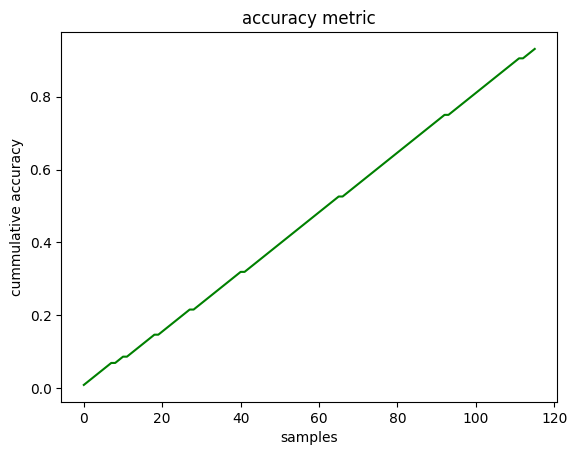

In [32]:
def main():
    df = pd.read_csv("data.csv")
    df = df.drop("id", axis="columns").drop("blank", axis="columns")
    df["diagnosis"] = np.where(df["diagnosis"] == 'M', 1, 0)
    df = df.sort_values(by="diagnosis")

    # For Knn
    knn = Knn(df, 0.8, 5)
    knn.test_kNN(False)

    # For Logistic Regression
    LogRef = Logistic_Reg(df, 0.8)
    LogRef.train_logistic_regression(0.1, 10, 0.5, True)

    return

main()

#### Discussion
KNN performs better only if accuracy is considered, however if the time complexity and other factors aretaken in account, it will be much slower for each test than model.

The more number of K allows for more points which are nearby the test point to be considered whenpredicting the class, this gives more coherent answer and we are able to get a higher accuracy.

The Limitations of Logistic Regression is the that if the weights are randomly initalised the number ofepochs to get the optimal solutions will vary. This causes drops in the model's accuracy. However oncetraining is done the mdoel will be much faster to predict.

Knn will have a stable accuracy at the cost of being computationally very slow. This is the majordisadvantage as the knn will have to calculate the sld for every test case paired with each training data.

KNN:
test accuracy:  0.9224137931034483
KNN:
test accuracy:  0.9137931034482759
KNN:
test accuracy:  0.9137931034482759
KNN:
test accuracy:  0.9310344827586207


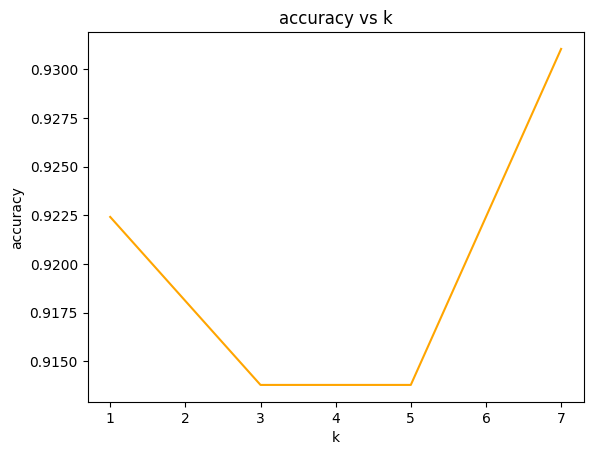

In [33]:
def Knn_analysis():
    df = pd.read_csv("data.csv")
    df = df.drop("id", axis="columns").drop("blank", axis="columns")
    df["diagnosis"] = np.where(df["diagnosis"] == 'M', 1, 0)
    df = df.sort_values(by="diagnosis")

    tests = []

    # Knn anlysis
    for i in range(1, 9, 2):
        knn = Knn(df, 0.8, i)
        val = knn.test_kNN(False)
        tests.append(val)

    plt.figure()
    plt.plot([(2 * i + 1) for i in range(len(tests))], tests, color='orange')
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.title('accuracy vs k')
    plt.show()

    return

Knn_analysis()